# Practical session demo #2 (solutions)

We are going to take a look at the different functionalities:
* Implement your own sampling strategy

In [1]:
# If f3dasm is not found, install the correct version from pip
try:
    import f3dasm
except ModuleNotFoundError:
    %pip install f3dasm==0.2.5 --quiet
    import f3dasm

2022-11-24 15:38:19.469515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 15:38:19.611363: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-24 15:38:20.314529: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:/usr/local/cuda-11.1/lib64
2022-11-24 15:38:20.314593: W ten

In [2]:
# Check if you got the right version, otherwise uninstall this version!

import os

if f3dasm.__version__ != '0.2.5':
    %pip uninstall -y f3dasm
    os._exit(00)
    # The kernel will be restarted and you need to run the notebook again!
    
print(f"Your f3dasm version is {f3dasm.__version__}!")

Your f3dasm version is 0.2.5!


import some other packages:

In [3]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple
import copy

We specify a seed:

In [4]:
seed = 42

## Implement your own sampler

In this part of the tutorial, we are going to take a closer look at the `f3dasm.SamplingInterface`

### What happens inside the samples

By executing the `get_samples()` function, the following happesn

* We split the parameters in the designspace to each of the categories (`ContinuousParameter`, `DiscreteParameter`, `CategoricalParameter`, `ConstantParameter`)
* Samples from the discrete and categorical dimensions are by default randomly sampled (`_sample_discrete()` and `_sample_categorical()`)
* Samples from the constant parameter are, well .. constant!
* Samples from the continuous parameters get samples by the samplingstrategy implemente by the `sample_continuous()` function
* All samples are concatenated to a numpy array
* The samples are converted to a `f3dasm.Data` object!



### Implement a new samples

Implementing a new sampler goes as follows

* We create a new class inhereting from the `f3dasm.SamplingInterface` class
* We have to implement our own `sample_continuous()` function:

> Note we can also implement sampling strategies for all the other parameters but this is not necessary

This `sample_continuous` function inputs the number of samples you want to create and returns a 2D numpy-array with the coordinates of those samples

In [5]:
class NewSampler(f3dasm.SamplingInterface):
    def sample_continuous(self, numsamples: int) -> np.ndarray:
        ...

### Example: GridSearch

We are going to create a new continuous sampling strategy.

The idea of grid search, or parameter sweep, is to equally partition the design space to a grid and sample on these grid points.

The proposed strategy is as follows:
* We will sample a $n$-dimensional grid of points according to the number of samples requested
* If we have sample budget left, these points are randomly sampled and added to the gridpoints

I'll help you through the mathematics so that you have to implement it:

Thought experiment: if we have a unit 2D grid and we want to sample 18 points according to this grid search strategy, we will have a grid of 4x4 and 2 points left.
The points per dimension $4$. We can calculate this `points_per_dimension` by taking the nth-root of `numsamples`:

In [6]:
numsamples = 18
dimensions = 2

points_per_dimension = int(np.power(numsamples, 1/dimensions))
print(f"Points per dimension is: {points_per_dimension}")

Points per dimension is: 4


The number of leftover samples is just substracting all the grid points from the total number of samples

In [7]:
leftovers = numsamples - points_per_dimension**dimensions
print(f"Leftover samples is: {leftovers}")

Leftover samples is: 2


To calculate the spacing for one dimension, we create a `spacing_list` denoting the coordinate of the grid points

We will start at the origin:

In [8]:
spacing_list = [i*(1/(points_per_dimension-1)) for i in range(points_per_dimension)]
spacing_list

[0.0, 0.3333333333333333, 0.6666666666666666, 1.0]

> Be aware that if the number of samples is less or equal than the $dim^2$, you will divide by $0$!

In order to create all grid points, we will consult the `product` function from the `itertools` library

In [9]:
from itertools import product

samples_gridsearch = np.array([item for item in product(spacing_list, repeat=dimensions)])
samples_gridsearch

array([[0.        , 0.        ],
       [0.        , 0.33333333],
       [0.        , 0.66666667],
       [0.        , 1.        ],
       [0.33333333, 0.        ],
       [0.33333333, 0.33333333],
       [0.33333333, 0.66666667],
       [0.33333333, 1.        ],
       [0.66666667, 0.        ],
       [0.66666667, 0.33333333],
       [0.66666667, 0.66666667],
       [0.66666667, 1.        ],
       [1.        , 0.        ],
       [1.        , 0.33333333],
       [1.        , 0.66666667],
       [1.        , 1.        ]])

***
**Exercise #1**

Implement the grid search sampler in the `f3dasm` framework

* Create the grid samples and make sure you are not using more points than the `numsamples`
* If you have remaining samples, sample them randomly and add them to the total generated samples
* If `numsamples` <= $dim^2$, you may raise an error
* In order to test your implementation, sample $123$ points on a 2D continuous space with bounds $-1.0$ and $1.0$
***

Some helpful functions:

* Remember, a sampler is initialized with a `f3dasm.DesignSpace` and a `seed`
* A list of the continuous parameters can be accessed with `self.design.get_continuous_input_parameters()`
* You can sample in a unit hypercube and stretch the samples to the boundaries of the designspace with the `self._stretch_samples(samples)` function

In [10]:
## YOUR CODE HERE ##

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='x0', ylabel='x1'>)

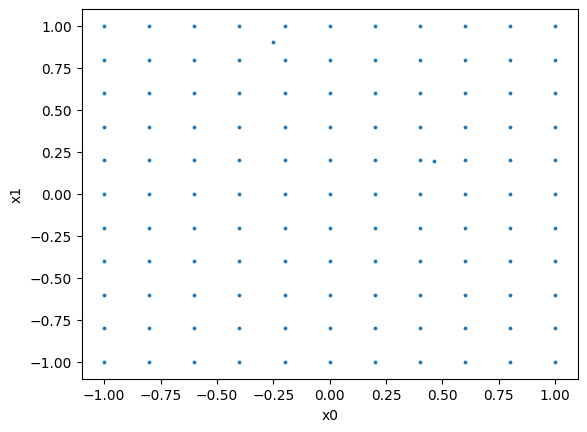

In [11]:
## SOLUTION ##

class GridSearch(f3dasm.SamplingInterface):
    def sample_continuous(self, numsamples: int) -> np.ndarray:
        continuous = self.design.get_continuous_input_parameters()
        dimensions = len(continuous)

        # Check if we have sufficient samples
        if numsamples <= dimensions**2:
            raise ValueError("number of samples is less than the square of the dimensionality!")

        points_per_dimension = int(np.power(numsamples, 1/dimensions))
        leftovers = numsamples - points_per_dimension**dimensions

        spacing_list = [i*(1/(points_per_dimension-1)) for i in range(points_per_dimension)]

        samples_gridsearch = np.array([item for item in product(spacing_list, repeat=dimensions)])
        samples_leftover = np.random.uniform(size=(leftovers, dimensions))

        # Concatenate the samples
        samples = np.concatenate([samples_gridsearch,samples_leftover])

        # Stretch the samples to the boundaries of the search space
        samples = self._stretch_samples(samples)

        return samples

dimensionality = 2
design = f3dasm.make_nd_continuous_design(bounds=np.tile([-1.,1.], (dimensionality,1)), dimensionality=dimensionality)

grid_sampler = GridSearch(design=design, seed=seed)
samples = grid_sampler.get_samples(numsamples=123)
samples.plot()

## Implement your own optimizer

Now we are going to implement a new benchmark function

First, we create a class storing the potential hyper-parameters for our optimizers. Even if we our optimizer doesn't have hyper-parameters, you still have to create class

This class has to be inhereted from the `f3dasm.OptimizerParameters` class. This inhereted class consists two mandatory attributes: 

* `population`: how many points are created for each update step. Defaults to 1
* `force_bounds`: if the optimizer is forced to stay between the design bounds. Defaults to True. Currently does not work when set to False!

In [12]:
@dataclass
class NewOptimizer_Parameters(f3dasm.OptimizerParameters):
 """Example of hyperparameters"""

 example_hyperparameter_1: float = 0.999
 example_hyperparameter_2: bool = True

Next, we create an new optimizer by inheriting from the `f3dasm.Optimizer` class

* We create a class attribute `parameter` and initialize it without any arguments in order to use the defaults specified above
* The only function we have to implement is the `update_step()` function, which takes a `f3dasm.Function` and outputs a tuple containing the position and evaluated value of the next iteration
* The `init_parameters()` function is optional. It can be used to store hyper-parameters that update throughout iterating

In [13]:
class NewOptimizer(f3dasm.Optimizer):
 """Example of implement your own optimizer"""

 parameter: NewOptimizer_Parameters = NewOptimizer_Parameters()

 def init_parameters(self):
    """Set the initialization parameters. This could be dynamic or static hyperparameters."""
    pass

 def update_step(self, function: f3dasm.Function) -> Tuple[np.ndarray, np.ndarray]:
    """Custom update step for your own optimizer

    Parameters
    ----------
    function
        objective function that is being optimized

    Returns
    -------
        tuple of resulting input and output parameter
    """



    return x, y

In order to use the optimizer, we call the `iterate()` method, which for-loops over the `update_step()` method, appending the `x` and `y` values to the internal data-object.

### Example: Momentum optimizer

As an exercise, we are going to code the momentum optimizer from scratch


$$
v_t = \gamma v_{t-1} + \lambda \nabla_x J(x_{t-1}) \\
x_t = x_{t-1} - v_t
$$

* $v_{t-1}$ the previous velocity
* $v_t$ the new velocity
* $x_{t_1}$ is the previous iteration
* $x_t$ the resulting iteration
* $\lambda$ is the learning rate
* $\nabla_x J(x_{t-1})$ the gradient of the previous iteration (can be calculated by the `dfdx()` method of the `f3dasm.Function`)

In [14]:
@dataclass
class Momentum_Exercise_Parameters(f3dasm.OptimizerParameters):
   """Example of hyperparameters"""

   momentum: float = 0.9
   learning_rate: float = 1e-3

class Momentum_Exercise(f3dasm.Optimizer):
   """Example of implement your own optimizer"""

   parameter: Momentum_Exercise_Parameters = Momentum_Exercise_Parameters()

   def init_parameters(self):
      """Set the initialization parameters. This could be dynamic or static hyperparameters."""
      self.velocity: np.ndarray = np.zeros(self.data.design.get_number_of_input_parameters())

   def update_step(self, function: f3dasm.Function) -> Tuple[np.ndarray, np.ndarray]:
      """Custom update step for your own optimizer

      Parameters
      ----------
      function
         objective function that is being optimized

      Returns
      -------
         tuple of resulting input and output parameter
      """

      x = self.data.get_input_data().iloc[-1].to_numpy()

      self.velocity = self.parameter.momentum * self.velocity  + self.parameter.learning_rate * function.dfdx(x)

      x_update = x - self.velocity
      y_update = function(x)

      return x_update, y_update

In [17]:
# We can put them in a dictionary if we want
iterations = 100

mon_optiizer = Momentum_Exercise(data=copy.copy(samples))
function = f3dasm.functions.Ackley(dimensionality=dimensionality, scale_bounds=design.get_bounds())


In [21]:
samples.get_input_data().iloc[-1].to_numpy()

array([0.46398788, 0.19731697])

In [49]:
xx = function.get_global_minimum(d=2)[0]
function.dfdx(xx)

ValueError: axes don't match array

In [51]:
import numdifftools as nd

x = np.array([0.1,0.1])
# TODO : fix the output shape (now it is shape=(dim*samples+1,), should be shape=(samples,1))
grad = nd.Gradient(function)
x = function._reshape_input(x)
output = np.empty(shape=(1, len(x[0, :])))
for i in range(len(x)):
    output = np.r_[output, np.atleast_2d(grad(np.atleast_2d(x[i, :])))]

output[1:]  # Cut of the first one because that is the empty array input

ValueError: axes don't match array

In [52]:
grad

In [60]:
grad(np.array([0.1,0.1]).T)

ValueError: axes don't match array

In [61]:
def ff(x):
    return np.sin(x) * x

g = nd.Gradient(ff)

In [65]:
g(np.array([0.1,0.3]))

array([[0.19933383, 0.        ],
       [0.        , 0.58212115]])

In [72]:
gg = nd.Gradient(function.__call__)

In [74]:
function(np.array([0.1,0.3]))

array([[21.39285613]])

In [75]:
gg(np.array([0.1,0.3]))

ValueError: axes don't match array

In [77]:
x = np.array([0.0,0.0])

In [79]:
function(x)

array([[21.78536238]])

In [80]:
h = np.ones([1e-6,1e-6])

In [84]:
(function(x+h) - function(x-h))/(2*h)

array([[83.53999166, 83.53999166]])